(300, 451, 3)


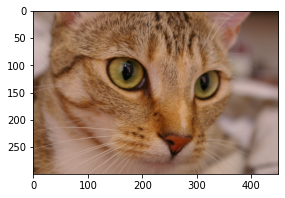

In [1]:
from skimage import data
import matplotlib.pyplot as plt

hr_image = data.chelsea() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

### 이미지 사이즈를 줄여서 저해상도 이미지로 만들기

(100, 150, 3)


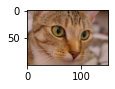

In [2]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150,100)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(3,1))
plt.imshow(lr_image)

### interpolation을 이용해 해상도를 다시 높이기

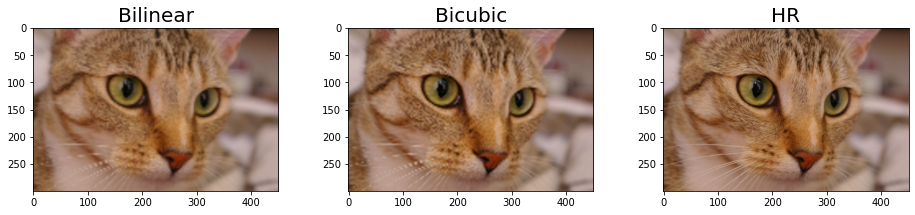

In [3]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

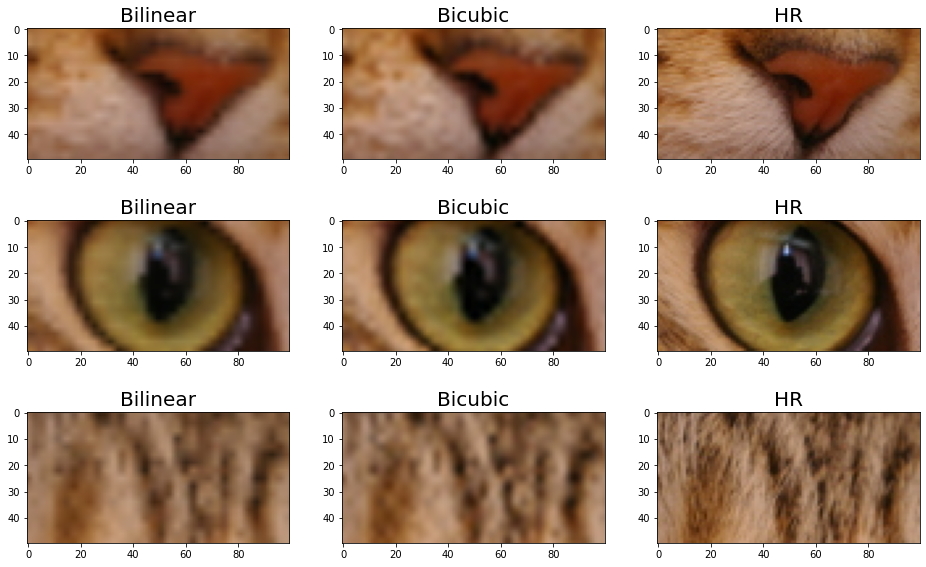

In [4]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

### SRCNN

### 데이터 가져오기

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


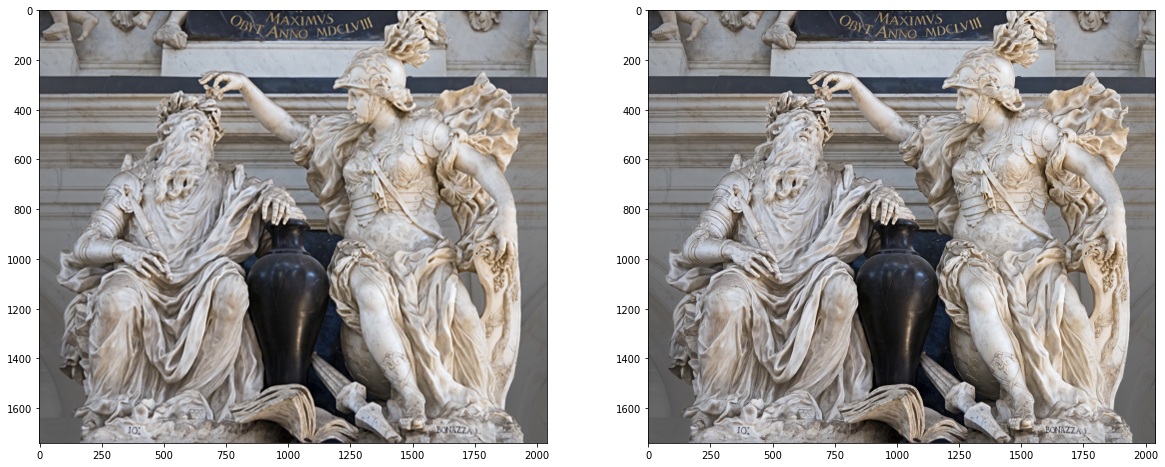

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

# 시각화를 위한 데이터 선택
for i, (lr, hr) in enumerate(valid):
    if i == 6: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)

Text(0.5, 1.0, 'HR')

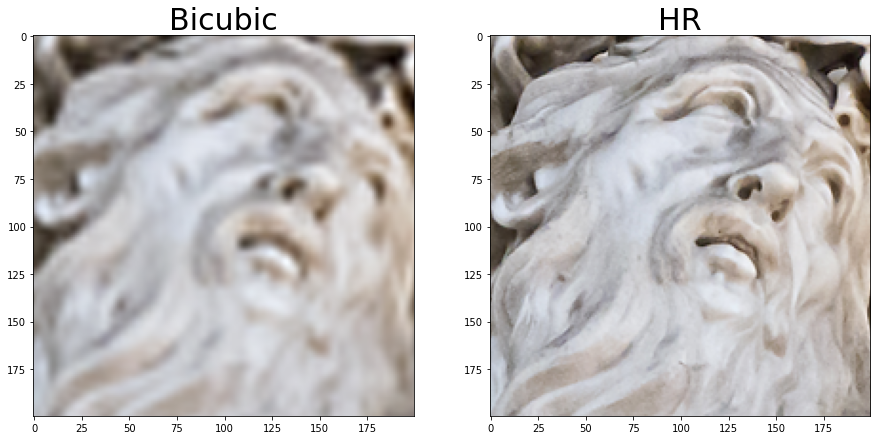

In [6]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

### SRCNN 적용
- 이미 학습된 srcnn이용

In [9]:
import tensorflow as tf

model_file = 'srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

In [10]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

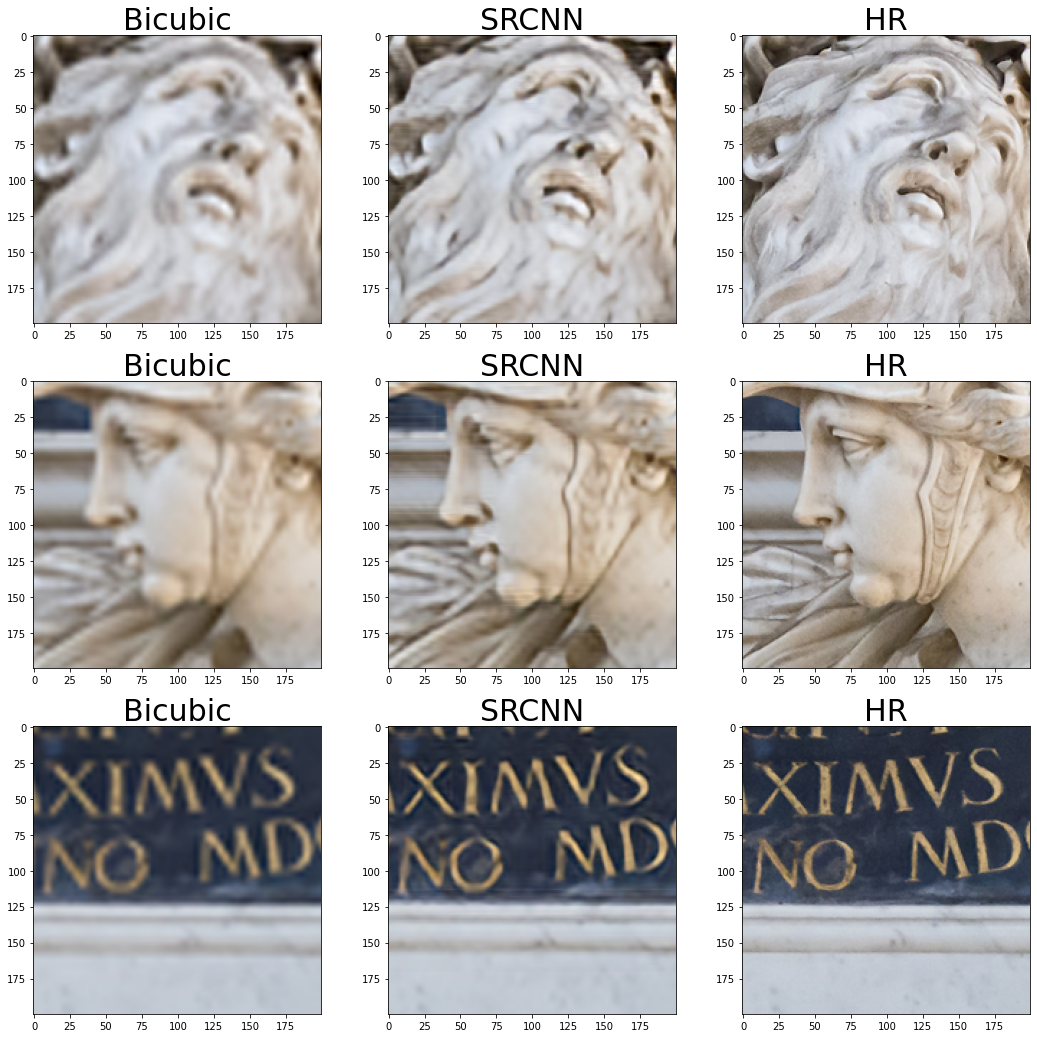

In [11]:
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### SRGAN 적용
- 이미 학습된 SRGAN 적용

In [12]:
model_file = 'srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [13]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)

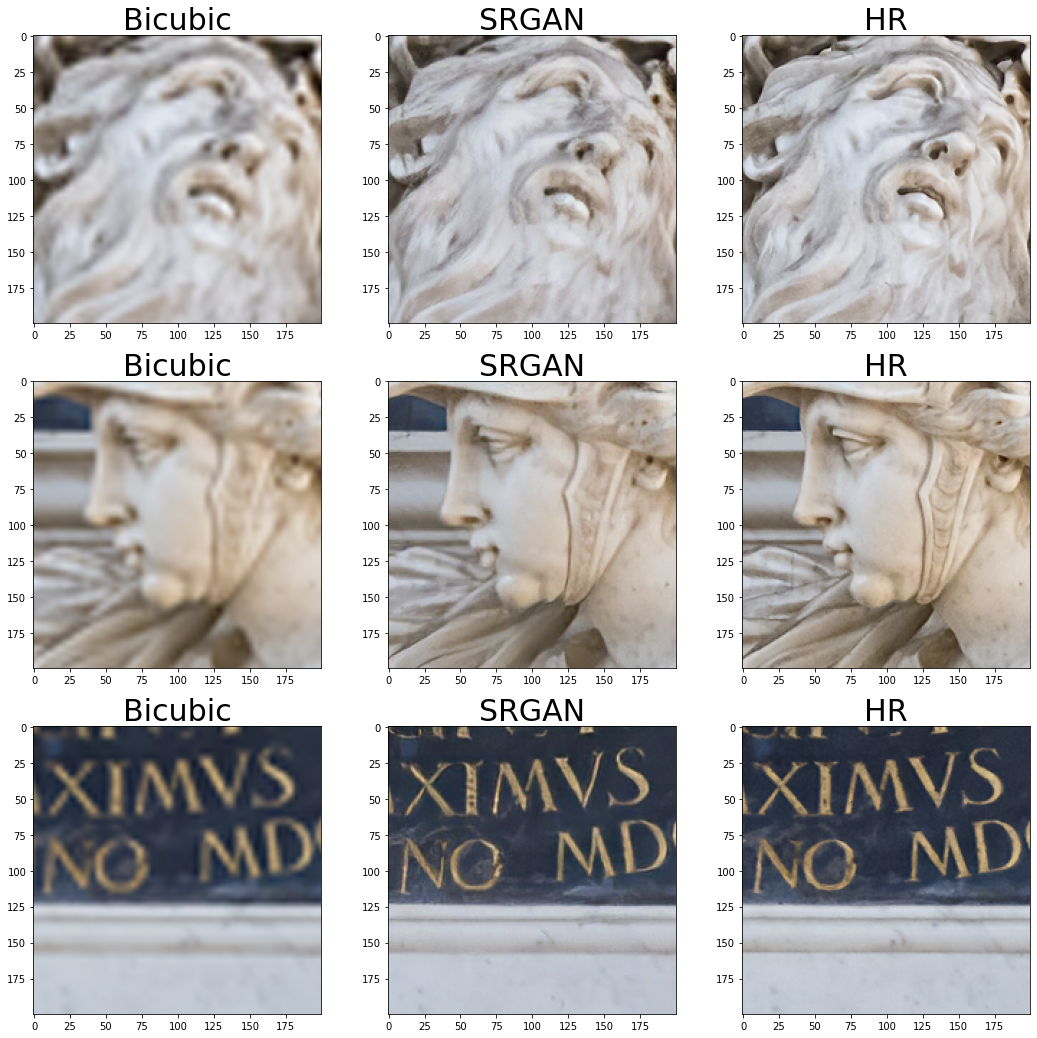

In [14]:
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)